# Overview:
This script will obtain historical price data from Yahoo and then perform a Monte Carlo Simulation by doing a random walk to forecast the reasonable ranges of prices.


**Parameters**

In [13]:
ticker                        = "GBPUSD=X"            # ticker symbol
hist_yyyy, hist_mm, hist_dd   = 2018, 11, 28          # start date, historical lookback
t0_yyyy, t0_mm, t0_dd         = 2023, 11, 28          # [t0] end date for historical lookback, and start date for simulations
tn_yyyy, tn_mm, tn_dd         = 2024, 9, 30           # [tn] end date for simulations (no. of periods to be determined based on no. of business days in between t0 and tn)
n_iters                       = 1000000               # No. of iterations for MCS


In [14]:
from datetime import date
import time
from pandas.tseries.offsets import BDay
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [15]:
assert n_iters > 800 # the minimum no. of iterations required for the 95% confidence interval to be within 0.1% of the mean [1]

# Processing source data:

In [16]:
# Alternative to importing yfinance as yf
def get_csv_link(date_from, date_to):
  _date_from = time.mktime(date_from.timetuple())
  _date_to = time.mktime(date_to.timetuple())
  s1 = "https://query1.finance.yahoo.com/v7/finance/download/"
  _s2 = str(int(_date_from))
  _s3 = str(int(_date_to))
  s4 = "?period1="+ _s2 +"&period2="+ _s3 +"&interval=1d&events=history&includeAdjustedClose=true"
  return s1 + ticker + s4
csv = pd.read_csv(get_csv_link(date(hist_yyyy, hist_mm, hist_dd), date(t0_yyyy, t0_mm, t0_dd)))
csv

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-11-27,1.281230,1.282051,1.272734,1.281230,1.281230,0.0
1,2018-11-28,1.274210,1.280607,1.273383,1.274372,1.274372,0.0
2,2018-11-29,1.282298,1.285182,1.275673,1.282413,1.282413,0.0
3,2018-11-30,1.278413,1.280688,1.273691,1.278445,1.278445,0.0
4,2018-12-03,1.275022,1.282429,1.270002,1.275348,1.275348,0.0
...,...,...,...,...,...,...,...
1300,2023-11-21,1.250907,1.255840,1.250578,1.250907,1.250907,0.0
1301,2023-11-22,1.254548,1.254878,1.244927,1.254422,1.254422,0.0
1302,2023-11-23,1.249110,1.256281,1.248985,1.249001,1.249001,0.0
1303,2023-11-24,1.253290,1.261670,1.252536,1.253353,1.253353,0.0


**Historical Returns**

*   pc = historical log returns, based on Adjusted Close
*   drift = mean minus half-variance of historical log returns



In [17]:
import numpy as np

adj_close = csv["Adj Close"]
pc = np.log(1+adj_close.pct_change()) 

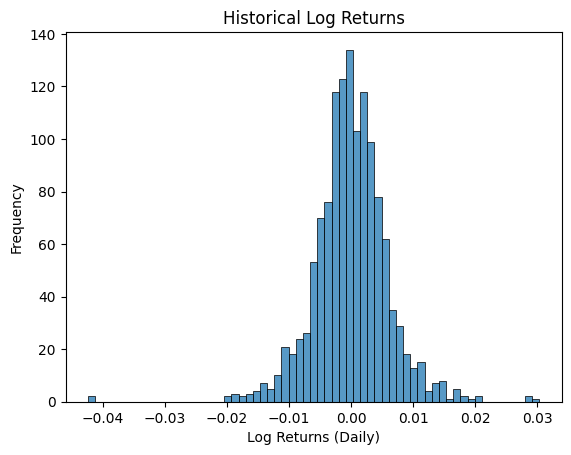

In [18]:
sb.histplot(pc.iloc[1:])
plt.title("Historical Log Returns")
plt.xlabel("Log Returns (Daily)")
plt.ylabel("Frequency");

In [19]:
mean = pc.mean()
var = pc.var()
stddev = pc.std()
drift = mean - 0.5*var
print("mean={}, var={}, drift={}".format(mean, var, drift))


mean=-1.279343782978319e-05, var=3.562709360720013e-05, drift=-3.0606984633383255e-05


# Performing Random Walk

In [20]:
date_t0 = date(t0_yyyy, t0_mm, t0_dd)
date_tn = date(tn_yyyy, tn_mm, tn_dd)

n_forecast = 0        # Counter++ for each business days existing in between t0 and tn
_t0 = date_t0         # tmp var.

while date(_t0.year,_t0.month,_t0.day) <= date(date_tn.year,date_tn.month,date_tn.day):
  n_forecast += 1
  _t0 += BDay(1)

In [21]:
# Init. array[n_forecast][n_iters] of zeros 
rand_returns = np.exp(drift + stddev * norm.ppf(np.random.rand(n_forecast,n_iters)))
sim_equity_curve = np.zeros_like(rand_returns)

# Assume single asset porfolio. Value of portfolio on day 1 of forecast is the Adj. Close price on that date. 
sim_equity_curve[0] = adj_close[len(adj_close)-1]

# Perform random walk and plot
for t in range(1,n_forecast):
    sim_equity_curve[t] = sim_equity_curve[t-1]*rand_returns[t]

assert(sim_equity_curve.shape==rand_returns.shape)

print("\n{}\nShape={}".format(ticker, sim_equity_curve.shape))
print("Simulation: From {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn)))



GBPUSD=X
Shape=(220, 1000000)
Simulation: From 2023-11-28 to 2024-09-30; Business days=219


In [22]:
count = 0
stdev_multi = 2

lower_bounds, center_ln, upper_bounds = [], [], []

print("{}\nt+n; \t\t\t\tstd \t\tmean \t\tmean - {}*std \t\tmean + {}*std \n"\
      .format(ticker, stdev_multi,stdev_multi))
for e in sim_equity_curve:
  std = e.std()
  mean = e.mean()
  lower_bounds.append(mean-2*std)
  center_ln.append(mean)
  upper_bounds.append(mean+2*std)
  print("t+{} \t{} \tstd = {} \tmean = {} \tlower = {} \t\tupper = {}"\
        .format(count, date_t0+BDay(count), std.round(2), mean.round(2), (mean-stdev_multi*std).round(2), (mean+stdev_multi*std).round(2)))
  count += 1


GBPUSD=X
t+n; 				std 		mean 		mean - 2*std 		mean + 2*std 

t+0 	2023-11-28 00:00:00 	std = 0.0 	mean = 1.26 	lower = 1.26 		upper = 1.26
t+1 	2023-11-29 00:00:00 	std = 0.01 	mean = 1.26 	lower = 1.24 		upper = 1.28
t+2 	2023-11-30 00:00:00 	std = 0.01 	mean = 1.26 	lower = 1.24 		upper = 1.28
t+3 	2023-12-01 00:00:00 	std = 0.01 	mean = 1.26 	lower = 1.23 		upper = 1.29
t+4 	2023-12-04 00:00:00 	std = 0.02 	mean = 1.26 	lower = 1.23 		upper = 1.29
t+5 	2023-12-05 00:00:00 	std = 0.02 	mean = 1.26 	lower = 1.23 		upper = 1.29
t+6 	2023-12-06 00:00:00 	std = 0.02 	mean = 1.26 	lower = 1.22 		upper = 1.3
t+7 	2023-12-07 00:00:00 	std = 0.02 	mean = 1.26 	lower = 1.22 		upper = 1.3
t+8 	2023-12-08 00:00:00 	std = 0.02 	mean = 1.26 	lower = 1.22 		upper = 1.3
t+9 	2023-12-11 00:00:00 	std = 0.02 	mean = 1.26 	lower = 1.21 		upper = 1.31
t+10 	2023-12-12 00:00:00 	std = 0.02 	mean = 1.26 	lower = 1.21 		upper = 1.31
t+11 	2023-12-13 00:00:00 	std = 0.02 	mean = 1.26 	lower = 1.21 		upper 

# Output

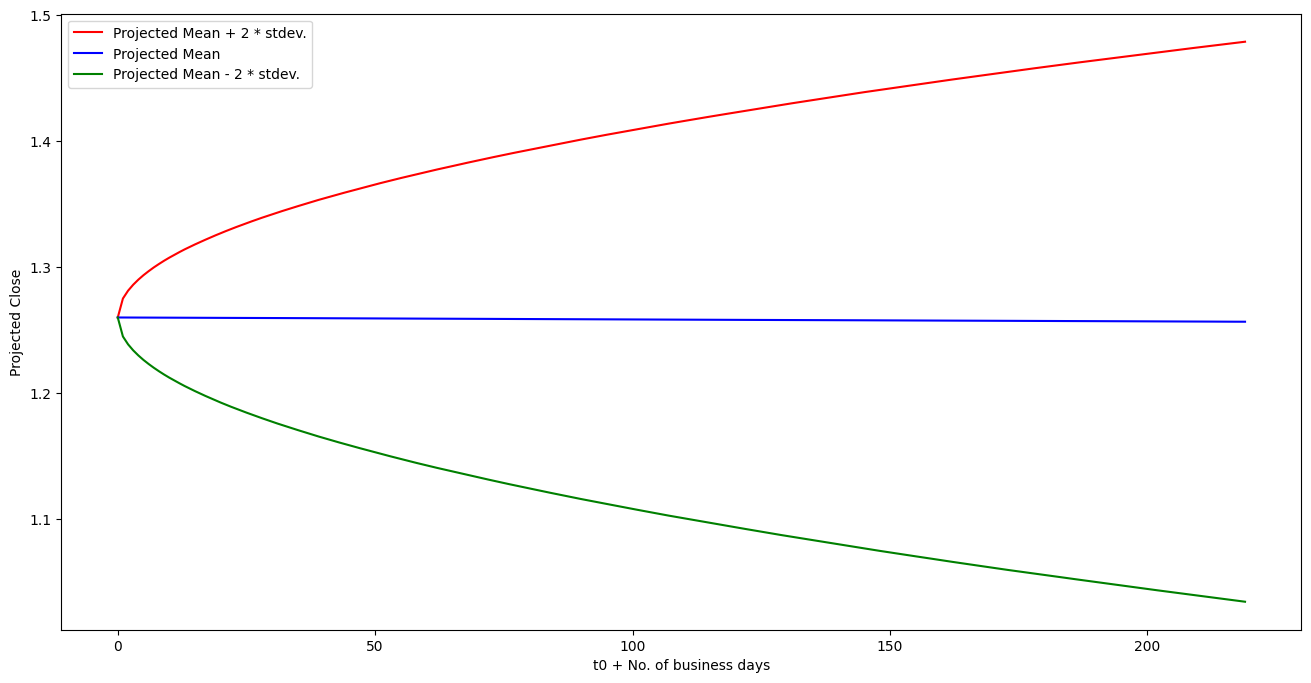

In [24]:
plt.figure(figsize=(16,8))
plt.plot(upper_bounds, label="Projected Mean + 2 * stdev.", color="red")
plt.plot(center_ln, label="Projected Mean", color="blue")
plt.plot(lower_bounds, label="Projected Mean - 2 * stdev.", color="green")
plt.legend()
plt.ylabel("Projected Close")
plt.xlabel("t0 + No. of business days")
plt.show()

In [23]:
print("Simulation:\tFrom {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn)))
print("\nOn t+{}:\tExpected Close; between the interval [{}, {}]".format(np.busday_count(date_t0, date_tn), round(lower_bounds[len(lower_bounds)-1],2),round(upper_bounds[len(upper_bounds)-1],2)))
print("\nOn t+{}:\tExpected average Close = {}".format(np.busday_count(date_t0, date_tn), round(center_ln[len(center_ln)-1],2)))

Simulation:	From 2023-11-28 to 2024-09-30; Business days=219

On t+219:	Expected Close; between the interval [1.03, 1.48]

On t+219:	Expected average Close = 1.26


<br>
<br>
<br>
<br>

---
**References:**

[1] E. Bukaçi, Th. Korini, E. Periku, S. Allkja and P. Sheperi (2016). Number of iterations needed in Monte Carlo Simulation using reliability analysis for tunnel supports. [online] https://www.ijera.com. Available at: https://www.ijera.com/papers/Vol6_issue6/Part%20-%203/J0606036064.pdf.